In [1]:
import torch
import torchvision
from torchvision.transforms import v2

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [3]:
import os
import requests
import zipfile

from pathlib import Path


data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"


if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
        )
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [71]:

simple_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(
            (224, 224)
        ),
        v2.ToDtype(torch.float32,scale=True),
        v2.Normalize(
            mean=[
                0.485,
                0.456,
                0.406,
            ],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

In [72]:
from going_modular.data_setup import create_dataloaders

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1bfaeb663f0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [73]:
from torchvision.models.efficientnet import efficientnet_b0,EfficientNet_B0_Weights

model_0 = efficientnet_b0(weights=EfficientNet_B0_Weights)

c:\Users\PREDATOR HELIOS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
for param in model_0.features.parameters():
    param.requires_grad = False

In [75]:
from torchinfo import summary

summary(model_0, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

In [76]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)
    ).to(device)

### Train model

In [77]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [78]:
from going_modular.engine import train
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:16<01:05, 16.48s/it]

Epoch: 1 | train_loss: 0.9769 | train_acc: 0.5667 | test_loss: 0.6458 | test_acc: 0.9040


 40%|████      | 2/5 [00:34<00:52, 17.48s/it]

Epoch: 2 | train_loss: 0.7049 | train_acc: 0.8125 | test_loss: 0.5287 | test_acc: 0.9006


 60%|██████    | 3/5 [00:58<00:40, 20.21s/it]

Epoch: 3 | train_loss: 0.5846 | train_acc: 0.8271 | test_loss: 0.4511 | test_acc: 0.8881


 80%|████████  | 4/5 [01:18<00:20, 20.38s/it]

Epoch: 4 | train_loss: 0.4542 | train_acc: 0.8854 | test_loss: 0.4097 | test_acc: 0.8881


100%|██████████| 5/5 [01:38<00:00, 19.69s/it]

Epoch: 5 | train_loss: 0.4536 | train_acc: 0.8917 | test_loss: 0.3801 | test_acc: 0.8977
[INFO] Total training time: 98.459 seconds


### Make predictions on the entire test dataset with the model

In [79]:
all_y_preds = []
all_y_true = []
all_y_pred_probs = []
all_samples = []

model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X,y = X.to(device),y.to(device)
        y_logits = model_0(X)
        y_preds = torch.softmax(y_logits,dim=1)
        y_labels = torch.argmax(y_preds,dim=1)

        all_samples.append(X.cpu())
        all_y_pred_probs.append(y_preds.cpu().max(dim=1).values)
        all_y_preds.append(y_labels.cpu())
        all_y_true.append(y.cpu())

all_y_preds = torch.cat(all_y_preds)
all_y_true = torch.cat(all_y_true)
all_y_pred_probs = torch.cat(all_y_pred_probs)
all_samples = torch.cat(all_samples)

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [80]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.3


In [81]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.3


In [82]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="multiclass",num_classes=len(class_names))
cm = confmat(all_y_preds,all_y_true)

tensor([[42,  3,  1],
        [ 0, 55,  3],
        [ 5,  3, 38]])

<Axes: >

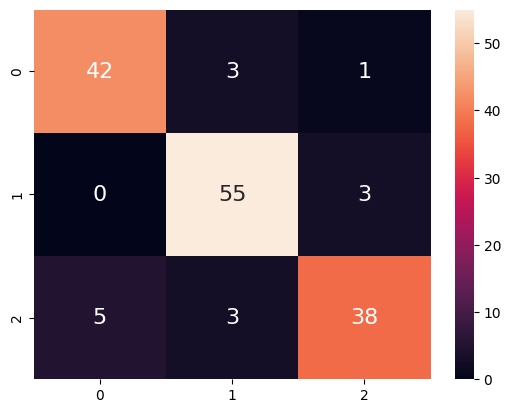

In [112]:
import seaborn as sns
import pandas as pd

df_cm = pd.DataFrame(cm)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [83]:
import pandas as pd 

data = {
    "Sample": [sample.numpy() for sample in all_samples],
    "Label": all_y_true,
    "Prediction": all_y_preds,
    "Prediction Probability": all_y_pred_probs,
}

df = pd.DataFrame(data)

In [62]:
top_5_most_wrong = df[df["Label"] != df["Prediction"]].nlargest(n=5,columns="Prediction Probability")

In [63]:
top_5_most_wrong

,Sample,Label,Prediction,Prediction Probability
43,"[[[1.6495421, 1.735166, 1.6837916, 1.5981679, ...",0,1,0.642461
122,"[[[-1.5699118, -1.5699118, -1.5356624, -1.5014...",2,0,0.600359
135,"[[[-0.81642264, -0.8335474, -0.81642264, -0.78...",2,0,0.550120
82,"[[[-1.9466565, -1.8781574, -1.8781574, -1.8439...",1,2,0.535904
144,"[[[-2.117904, -2.117904, -2.117904, -2.117904,...",2,1,0.509834


In [70]:
top_5_most_wrong.loc[43]["Sample"].shape

(3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


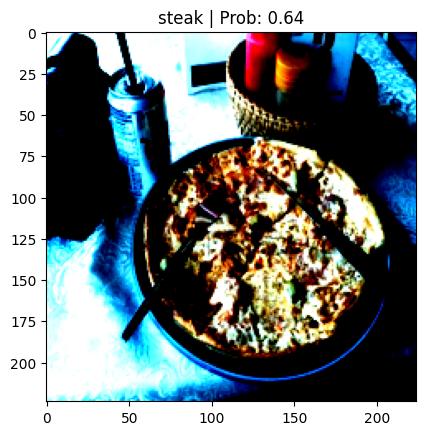

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


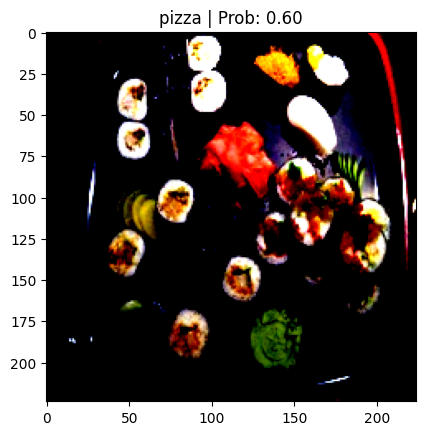

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.605142].


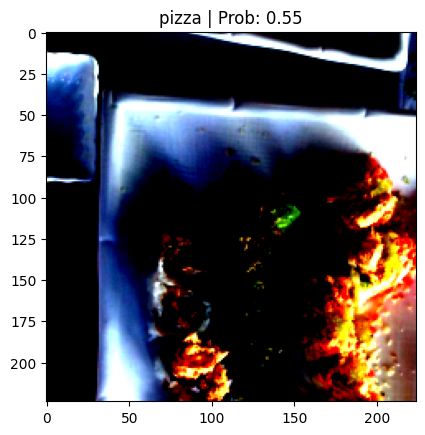

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


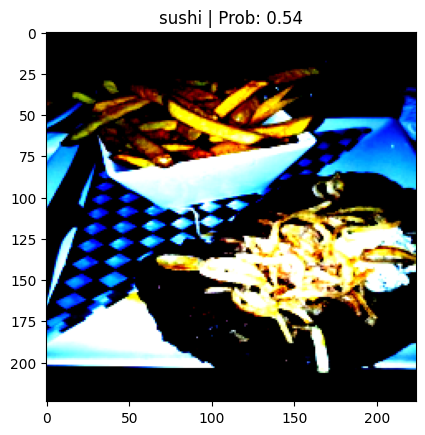

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


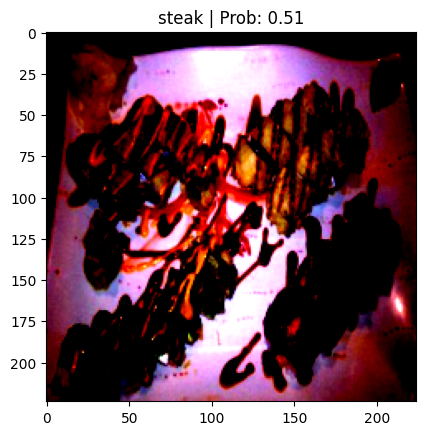

In [111]:
import matplotlib.pyplot as plt

for index,wrong_pred in top_5_most_wrong.iterrows():


    pred_name = class_names[wrong_pred["Prediction"]]
    plt.title(f'{pred_name} | Prob: {wrong_pred["Prediction Probability"]:.2f}')
    plt.imshow(torch.tensor(wrong_pred["Sample"]).permute(1, 2, 0))
    plt.show()  # Add this to display each image individually